We will start with the microsoft/deberta-v3-base model. And the MRPC subset of GLUE.

In [ ]:
!pip install transformers
!pip install datasets
!pip3 install torch torchvision
!pip install ipywidgets widgetsnbextension pandas-profiling
!pip install accelerate -U
!pip install evaluate
!pip install scikit-learn
!pip install numpy==1.26.4

In [16]:
# AutoModelForSequenceClassification is adding a classification head on top of the pretrained model. 
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
import evaluate
import numpy as np
import os
import json
from transformers import EvalPrediction
import torch.nn.functional as F
from transformers import get_scheduler
from torch.optim import AdamW
import pandas as pd
import matplotlib.pyplot as plt



## Load Data

### Load Model Tokenizer and configuration
Here are the documentation for deberta-v3-base model:

    https://huggingface.co/transformers/v4.9.1/model_doc/deberta_v2.html
For config:

    https://huggingface.co/docs/transformers/v4.41.3/en/main_classes/configuration#transformers.PretrainedConfig



In [17]:
MODEL_NAME = "microsoft/deberta-v3-base"
config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 2
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,use_fast=False)

/Users/samyiin/Projects/ParaphraseAnalysis/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


*2024.06.17*   
I enountered a issue while loading the tokenizer, here is a post that solved the problem (make sure to restart the kernal): 
    
    https://discuss.huggingface.co/t/error-with-new-tokenizers-urgent/2847  
The "use_fast" parameter is from this post.    
Another question is whether we should set the number of labels to be 1 or 2, since this is looking like a binary classification problem. But according to this website, 2 is also acceptable:  

    https://stackoverflow.com/questions/71768061/huggingface-transformers-classification-using-num-labels-1-vs-2

In [18]:
datasets = load_dataset("nyu-mll/glue", "mrpc")

### Representation
The first problem I face is how to represent paraphrase: Paraphrase data is made of two sentences and a label indicationg whether they are paraphrase. So the label is clearly the output, what should the input look like? Here we found an good answer: 
    
    https://huggingface.co/transformers/v3.0.2/glossary.html#token-type-ids

*2024.06.17*   
I encounter a problem: when I try to convert dataset to torch format, and then I try to access the first item of the train set, it shows this error:   
ValueError: Unable to avoid copy while creating an array as requested.  
So I found a solution in this website: the problem can be fixed by downgrading numpy. 

    https://support.gurobi.com/hc/en-us/articles/25787048531601-Compatibility-issues-with-numpy-2-0#:~:text=ValueError%3A%20Unable%20to%20avoid%20copy,4).  


In [19]:
# tokenize the entire dataset: I make sure we pad every sentence (pair) to token length of 102
# I first use tokenizer() to tokenize the entire train,test,val set separately, and see that the maximum length of tokens is 102. 
def tokenize(sample):
    tokenized_dataset = tokenizer(
        sample['sentence1'],
        sample['sentence2'],  
        truncation=True,               # Truncate sequences longer than the model's max length
        padding='max_length',          # Pad to the maximum length
        max_length = 102,              # I tried to pad them separately and see that the max length of token is 102
        return_token_type_ids=True,    # Return token type IDs: Deberta use this to differentiate two sentences
        return_attention_mask=True,    # Return attention mask: to tell the model what is the padding part.
    )
    return tokenized_dataset

tokenized_datasets = datasets.map(tokenize, batched =True) 
tokenized_datasets = tokenized_datasets.remove_columns(['sentence1','sentence2','idx'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

## Define Training process

### Define helper functions

In [20]:
TRAIN_VAL_STAGE = 'train_and_validate'
TEST_STAGE = 'test'
metric = evaluate.load("accuracy",)

def compute_metrics(p):
    '''
    This function calculates the accuracy of predictions
    '''
    preds = np.argmax(p.predictions, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)

def construct_epoch_dir(output_dir, epoch):
    '''
    This function simply construct the directory name to store training data of each epoch
    '''
    epoch_dir = os.path.join(output_dir, f'epoch={epoch}')
    if not os.path.exists(epoch_dir):
        os.makedirs(epoch_dir)
    return epoch_dir
    
def construct_metrics_record_filename(epoch_dir, stage):
    '''
    This function simply construct the directory and file name for the file that we store the training and evaluating data.
    '''
    json_file = os.path.join(epoch_dir,f'{stage}_metrics.json')
    return json_file

def record_config(output_dir, hyper_parameters):
    '''
    This function records the hyper parameters of each training, and write to a file under the training directory
    '''
    hyper_parameters_file = os.path.join(output_dir, 'hyper_parameters.json')
    with open(hyper_parameters_file, 'w') as f:
        json.dump(hyper_parameters, f)
    
def record_metrics(output_dir, epoch, records, stage=TRAIN_VAL_STAGE):
    '''
    This function will record the loss and accuracy during training and evaluation. 
    '''
    epoch_dir = construct_epoch_dir(output_dir, epoch)
    json_file = construct_metrics_record_filename(epoch_dir, stage)
    with open(json_file, 'w') as f:
        json.dump(records, f, indent=4)
    return epoch_dir

def record_epoch_train_results(model, output_dir, epoch, records):
    '''
    This function will save the current trained model and the training loss and accuracy.
    '''
    epoch_dir = record_metrics(output_dir, epoch, records)
    model.save_pretrained(epoch_dir)


### Define evaluate Function
Basically the same with train function, but with no grad so it will be more efficient

In [21]:
def evaluate_model(model, dataloaders, device, subsample_size=408, evaluate_set='validation'):
    '''
    This function will evalueate the given model. 
    evaluate means validate or test
    '''
    # set model to eval mode
    model.eval()
    # calculate number of samples being evaluated
    total_validated_samples = 0
    # calculate total loss and total number of correct labels (weighted acuracy)
    total_loss = 0
    total_accurate = 0
    # turn off grad computation
    with torch.no_grad():  
        # evaluate batch by batch
        for step, batch in enumerate(dataloaders[evaluate_set]):
            # get the size of this batch
            batch_size = batch['labels'].shape[0]
            # forward pass in the model
            batch =  {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            # add loss to total loss
            loss = F.cross_entropy(input=outputs.logits, target=batch['labels'])
            total_loss += loss.item()
            # add weighted accuracy to total accuracy
            pred_and_tags = EvalPrediction(predictions=outputs.logits.detach().numpy(), label_ids=batch['labels']) 
            accuracy = compute_metrics(pred_and_tags)['accuracy']
            total_accurate += accuracy * batch_size
            # add batch size to total number of validated samples
            total_validated_samples += batch_size
            # terminate the process if we are subsampling
            if total_validated_samples > subsample_size:
                break

    # calculate the loss and accuracy
    average_loss = total_loss/total_validated_samples
    average_accuracy = total_accurate/total_validated_samples
    return average_loss, average_accuracy

### Define train function

In [22]:
# use the EvalPrediction as in the trainer class's compute_metrics parameter. 
def train_epoch(model, epoch, dataloaders, device, optimizer, scheduler):
    '''
    This function will train the given model for an epoch
    '''
    records = []
    for step, batch in enumerate(dataloaders['train']):
        # put everything on the right device
        batch =  {k: v.to(device) for k, v in batch.items()}
        # clear gradients, same old as usual
        optimizer.zero_grad()
        # the batch already includes the 'labels' (y) and the input_ids, masks, input_type_ids (x). 
        outputs = model(**batch)
        # outputs.loss might be problematic because of the NllLossBackward0 without softmax, should use nn.CrossEntropy
        loss = F.cross_entropy(input=outputs.logits, target=batch['labels'])
        loss.backward()
        # back propagation
        optimizer.step()
        # scheduler adjust lr
        scheduler.step()
        # record the train loss and accuracy
        pred_and_tags = EvalPrediction(predictions=outputs.logits.detach().numpy(), label_ids=batch['labels'])            
        record = {"epoch":epoch, "batch":step, "train_loss":loss.item(), "train_accuracy":compute_metrics(pred_and_tags)['accuracy']}
        # validate the model
        val_loss, val_accuracy = evaluate_model(model, dataloaders, device, subsample_size=100)
        record.update({"val_loss": val_loss, 'val_accuracy': val_accuracy, 'val_subsample_size': 100})
        print(record)
        # append record to the output
        records.append(record)
    return model, records
    

In [23]:
def train_model(model, tokenized_datasets, hyper_parameters, output_dir):
    '''
    This function will train the given model for given number of epochs
    '''
    # batch size: the name is a bit weird because TrainingArguments can do it on multiple GPUs
    per_device_train_batch_size = hyper_parameters['per_device_train_batch_size']
    # initialize dataloaders
    dataloaders = {}
    dataloaders['train'] = DataLoader(tokenized_datasets['train'], batch_size=per_device_train_batch_size, shuffle=True)
    dataloaders['test'] = DataLoader(tokenized_datasets['test'], batch_size=per_device_train_batch_size)
    dataloaders['validation'] = DataLoader(tokenized_datasets['validation'], batch_size=per_device_train_batch_size, shuffle=True) # shuffle because we want to subsample
    
    # initialize optimizer
    learning_rate = hyper_parameters['learning_rate']
    optimizer = AdamW(model.parameters(),lr=learning_rate)  # Here `model` is assumed to be instantiated
    
    # scheduler
    lr_scheduler_type = hyper_parameters['lr_scheduler_type']
    lr_scheduler_kwargs = { 'optimizer':optimizer, **hyper_parameters['lr_scheduler_kwargs']}
    scheduler = get_scheduler(lr_scheduler_type, **lr_scheduler_kwargs)

    # number of epochs
    num_train_epochs = hyper_parameters['num_train_epochs']
    
    # Create the subdirectory for the hyperparameters: this directory is where we will save the result of trainning
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # WRITE hyperparameter to subdirectory
    record_config(output_dir, hyper_parameters)

    # get device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # train the model on the hyper parameters
    for epoch in range(num_train_epochs):
        mdoel, records = train_epoch(model, epoch, dataloaders, device, optimizer, scheduler)
        # WRITE: save the result for this epoch
        record_epoch_train_results(model, output_dir, epoch, records)
        
        # at the end of each epoch, evaluate the model with full size
        val_loss, val_accuracy = evaluate_model(model, dataloaders, device)
        test_loss, test_accuracy = evaluate_model(model, dataloaders, device, subsample_size=1725, evaluate_set='test')

        # update the last time record: validate with full sample
        last_record = records.pop()
        last_record.update({"val_loss": val_loss, 'val_accuracy': val_accuracy, 'val_subsample_size': 408, 
                            'test_loss':test_loss,  'test_accuracy': test_accuracy, 'test_subsample_size':1725})
        # WRITE test result to subdirectory
        record_metrics(output_dir, epoch, last_record, stage=TEST_STAGE)
        print(last_record)

    

## Run: Hyper parameter tuning

In [ ]:
base_dir = 'deberta_output/'
# Create the base directory if it doesn't exist
if not os.path.exists(base_dir):
    os.makedirs(base_dir)


for lr in [5e-05, 5e-04, 5e-06]:
    for per_device_train_batch_size in [32, 16]:
        for num_train_epochs in [4]: # this I am only running one experiment
            # calculate the arguments for shceduler: it depends on the sample size, batch size and epochs
            train_sample_size = len(tokenized_datasets['train'])
            # Here what I fixed is the warm up steps percentage=10%, so the warm up steps will be depend on num_epochs
            num_training_steps = int((train_sample_size/per_device_train_batch_size) * num_train_epochs)
            num_warmup_steps = int(0.1 * num_training_steps)
            # I will keep the name of hyper parameters consistent with TrainingArguments so that later I can switch to it. 
            hyper_parameters = {
                'learning_rate': lr,
                'per_device_train_batch_size': per_device_train_batch_size,
                'lr_scheduler_type': 'linear',
                'num_train_epochs': num_train_epochs,
                'lr_scheduler_kwargs': {'num_warmup_steps':num_warmup_steps,
                                        'num_training_steps':num_training_steps},
            }
            
            # todo: here should be better
            tuned_parameters = ['learning_rate','per_device_train_batch_size', 'lr_scheduler_type']
            output_dir = os.path.join(base_dir, '_'.join([f"{k}={hyper_parameters[k]}" for k in tuned_parameters]))
            
            # load a fresh pre-trained model
            model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
            # train and evaluate and save the result
            train_model(model, tokenized_datasets, hyper_parameters, output_dir)

## Results
After a long periods of running, we saved our results in
    
    deberta_output/(dir_named_by_hyperparam)/(epoch_number)
Now we will retrieve the results and do graphs

In [28]:
base_dir = 'deberta_output/'
output_dir_list = []
for lr in [5e-05, 5e-04, 5e-06]:
    for per_device_train_batch_size in [32, 16]:
        output_dir = f"learning_rate={lr}_per_device_train_batch_size={per_device_train_batch_size}_lr_scheduler_type=linear"
        output_dir = os.path.join(base_dir, output_dir)
        output_dir_list.append(output_dir)
output_dir_list

['deberta_output/learning_rate=5e-05_per_device_train_batch_size=32_lr_scheduler_type=linear',
 'deberta_output/learning_rate=5e-05_per_device_train_batch_size=16_lr_scheduler_type=linear',
 'deberta_output/learning_rate=0.0005_per_device_train_batch_size=32_lr_scheduler_type=linear',
 'deberta_output/learning_rate=0.0005_per_device_train_batch_size=16_lr_scheduler_type=linear',
 'deberta_output/learning_rate=5e-06_per_device_train_batch_size=32_lr_scheduler_type=linear',
 'deberta_output/learning_rate=5e-06_per_device_train_batch_size=16_lr_scheduler_type=linear']

In [40]:
all_train_results = []
all_test_results = []
num_train_epochs = 4
for output_dir in output_dir_list:
    all_epoch_train_results = []
    all_epoch_test_results = []
    # get all results
    for epoch in range(num_train_epochs):
        # construct each epoch's directory under subdirectory
        epoch_dir = construct_epoch_dir(output_dir, epoch)
        # combine all train results
        train_result_file = construct_metrics_record_filename(epoch_dir, stage=TRAIN_VAL_STAGE)
        with open(train_result_file, 'r') as f:
            epoch_train_result = json.load(f)
        all_epoch_train_results.extend(epoch_train_result)
        # also get all the test results
        test_result_file = construct_metrics_record_filename(epoch_dir, stage=TEST_STAGE)
        with open(test_result_file, 'r') as f:
            epoch_test_result = json.load(f)
        all_epoch_test_results.append(epoch_test_result)

    
        
    # put all results as a list of tuples
    all_train_results.append((f"{output_dir}", pd.DataFrame(all_epoch_train_results)))
    all_test_results.append((f"{output_dir}", pd.DataFrame(all_epoch_test_results)))
        

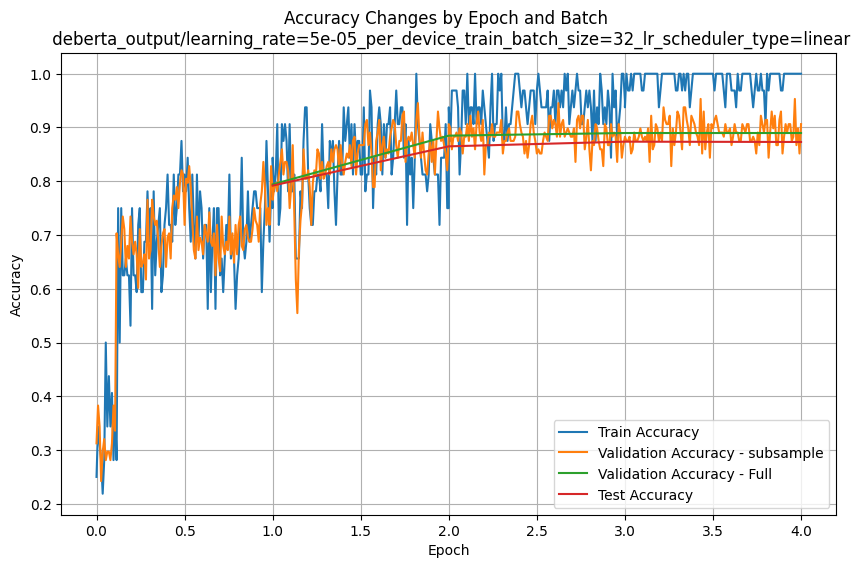

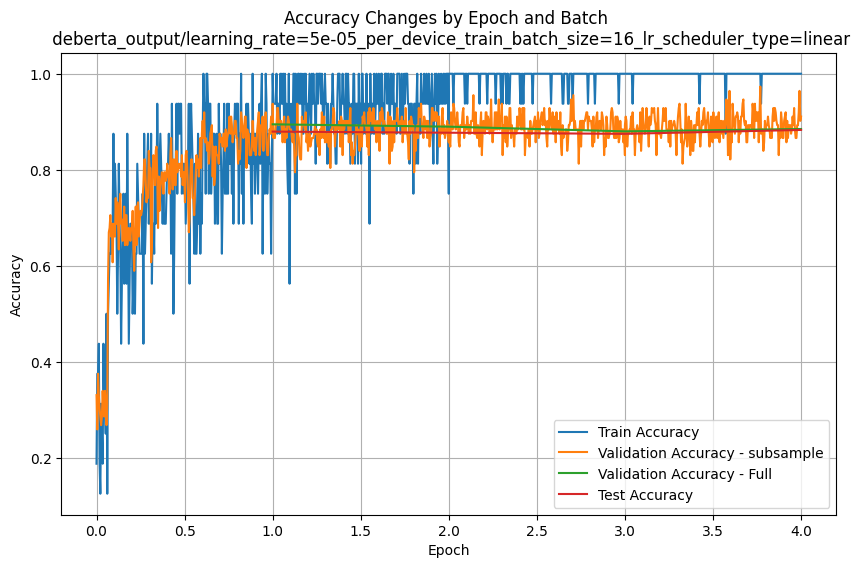

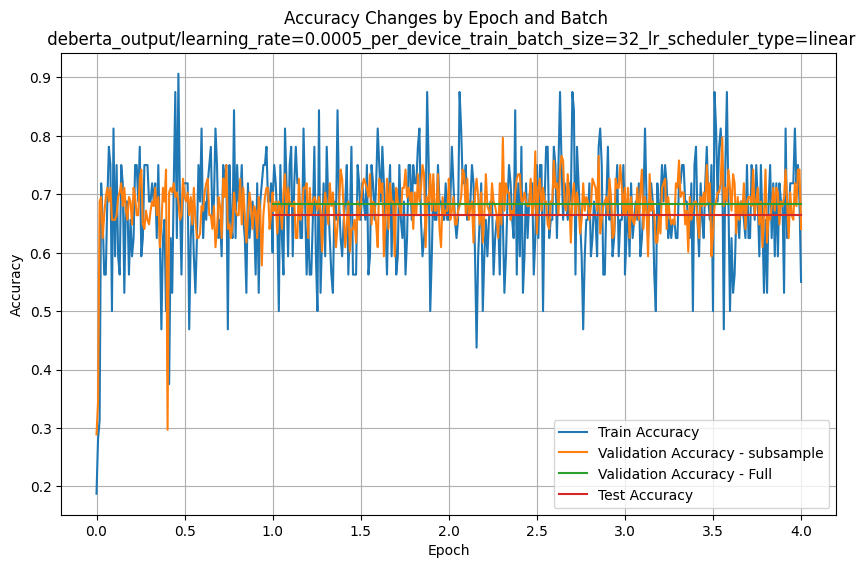

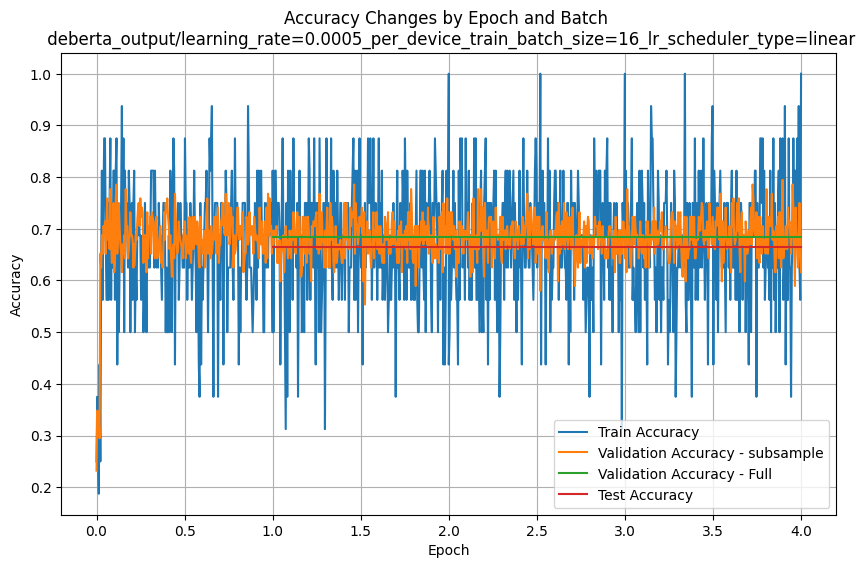

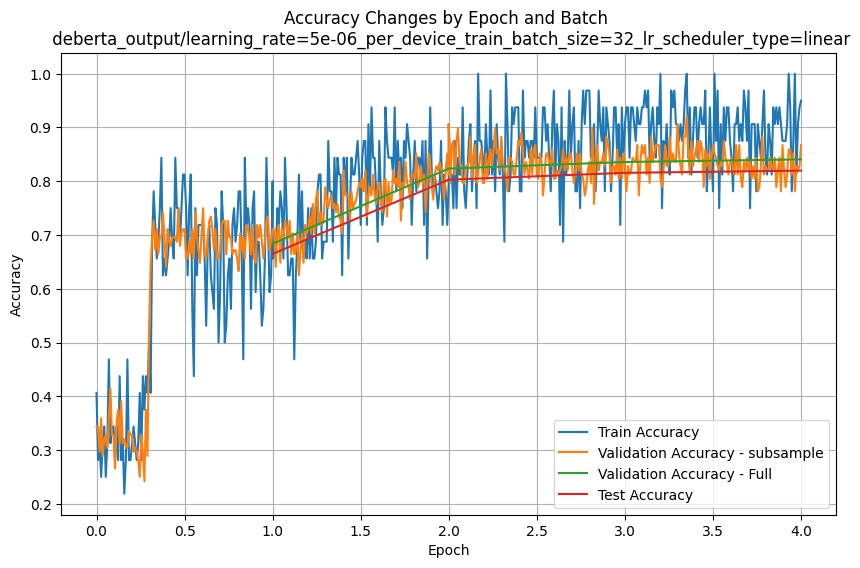

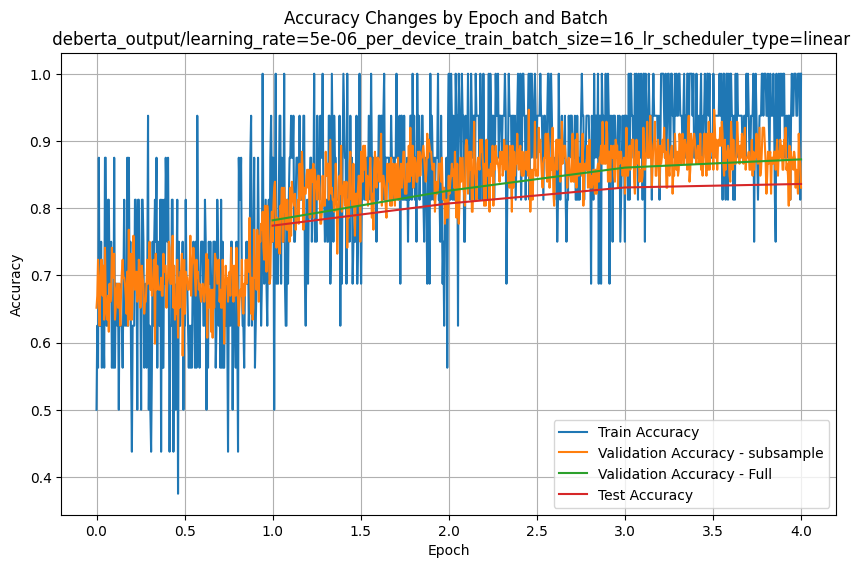

In [42]:
def plot_result(plt, df, list_target_columns, list_target_columns_ledgends):
    # make the x axis continuous throughout time
    df['epoch_batch'] = df['epoch'] + df['batch'] / (df['batch'].max())
    for target_column, ledgend in zip(list_target_columns, list_target_columns_ledgends):
        plt.plot(df['epoch_batch'], df[target_column], label=ledgend)
    return plt

for (hyper_param_str_train, df_train), (hyper_param_str_eval, df_eval) in zip(all_train_results, all_test_results):
    # Plotting
    plt.figure(figsize=(10, 6))

    # hyper_param_str_train and hyper_param_str_eval are the same
    plot_title = f'Accuracy Changes by Epoch and Batch \n {hyper_param_str_train}'
    y_label = "Accuracy"

    # first plot the train result
    list_target_columns = ['train_accuracy', 'val_accuracy']
    list_target_columns_ledgends = ['Train Accuracy', 'Validation Accuracy - subsample']
    plt = plot_result(plt, df_train, list_target_columns, list_target_columns_ledgends)

    # then plot the test result
    list_target_columns = ['val_accuracy', 'test_accuracy']
    list_target_columns_ledgends = ['Validation Accuracy - Full', 'Test Accuracy']
    plt = plot_result(plt, df_eval, list_target_columns, list_target_columns_ledgends)
    
    # set basic informations
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.show()
